In [1]:
import cv2
import numpy as np
import os
from tqdm import tqdm 
from ocr import page, words

In [13]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def display_image_with_bounding_boxes(image):
    cv2.imshow("Image with Bounding Boxes", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

output_folder = "cropped_letters"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Load the image
image = cv2.imread(r"D:\Projects\AIML\DIGILIPI\WhatsApp Image 2025-02-14 at 20.42.59_238b7707.jpg")
image = page.detection(image)  # Ensure `page.detection()` is correctly defined

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary inverse thresholding
_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV) 

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Total contours detected: {len(contours)}")

cropped_letters = []

padding = 10 

for i, contour in tqdm(enumerate(contours), total=len(contours), desc="Processing Contours", unit="contour"):
    x, y, w, h = cv2.boundingRect(contour)
    
    if w > 10 and h > 10 and cv2.contourArea(contour) > 50: 
        x_pad = max(x - padding, 0)
        y_pad = max(y - padding, 0)
        w_pad = min(x + w + padding, image.shape[1]) - x_pad
        h_pad = min(y + h + padding, image.shape[0]) - y_pad
        
        # Crop the letter region (without drawing bounding boxes)
        letter = image[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]

        # Convert to grayscale
        letter_gray = cv2.cvtColor(letter, cv2.COLOR_BGR2GRAY)
        
        # Threshold to remove background (white -> transparent, black -> white)
        _, letter_thresh = cv2.threshold(letter_gray, 150, 255, cv2.THRESH_BINARY_INV)
        
        # Convert black to white and keep white transparent
        letter_alpha = cv2.merge((letter_thresh, letter_thresh, letter_thresh, letter_thresh))

        # Save as PNG with transparency
        filename = os.path.join(output_folder, f'letter_{len(cropped_letters) + 1}.png')
        cv2.imwrite(filename, letter_alpha)
        
        cropped_letters.append(letter_alpha)

# Display the original image with bounding boxes
display_image_with_bounding_boxes(image)


Total contours detected: 8


Processing Contours: 100%|██████████| 8/8 [00:00<00:00, 109.57contour/s]


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
# model = tf.keras.models.load_model('malayalam_handwriting_model.h5')

In [5]:
def preprocessing_fun(img):
    img=np.where(img>0.5,1,0)
    return img

In [6]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_fun)

In [7]:
test_generator = test_datagen.flow_from_directory(
        'cropped_letters',
        target_size=(128,128),
        batch_size=1,
        class_mode='categorical',color_mode="grayscale"
)

Found 0 images belonging to 0 classes.


In [8]:
from tensorflow.keras.models import load_model
import pickle
from tqdm import tqdm

import glob


In [9]:
test_fold=sorted(glob.glob("cropped_letters/*"))

In [10]:
model = load_model("D:\Projects\AIML\DIGILIPI\Malayalam_detection.h5")
print("Keras model loaded successfully!")
max_length = 100 


with open("detail.pkl", 'rb') as f:
    loaded_pickle_data = pickle.load(f)

# model = model_from_json(loaded_pickle_data['model'])
# model.set_weights(loaded_pickle_data['weights'])

# tokenizer = loaded_pickle_data['tokenizer']
class_labels = loaded_pickle_data['class_labels']

print("Pickle model, tokenizer, and label encoder loaded successfully!")
from sklearn.metrics import classification_report
target_names = loaded_pickle_data['target_names']



Keras model loaded successfully!
Pickle model, tokenizer, and label encoder loaded successfully!


['cropped_letters\\letter_1.png']


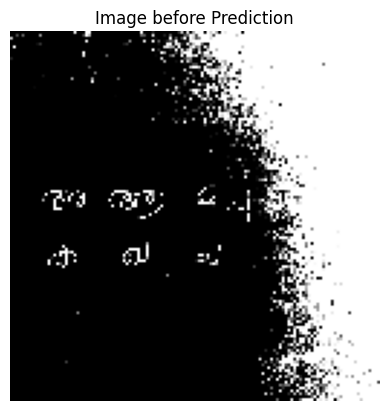

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]
[28]


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

y_pred = []
file_list = []
print(test_fold)

for img in test_fold:
    i = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    i = cv2.resize(i, (128, 128), interpolation=cv2.INTER_LINEAR)
    
    # Show the image before prediction
    plt.imshow(i, cmap='gray')
    plt.title("Image before Prediction")
    plt.axis("off")
    plt.show()
    
    # Prepare for model prediction
    i = np.reshape(i, (1, 128, 128, 1))

    prediction = model.predict(i, verbose=0)
    print(prediction)
    
    p = np.argmax(prediction[0])
    y_pred.append(int(class_labels[p]))
    target_names[p]

print(y_pred)


            